In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
import pickle
import requests
import os
from bs4 import BeautifulSoup
import time, random
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingRandomSearchCV, HalvingGridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/archana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/archana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/archana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Data Collection
Load the pickle file saved at the end of GetBookId notebook which is where all data collection is done.

In [4]:
with open('data/books_df_clean.pkl', 'rb') as f:
    books_df = pickle.load(f)

### Data Understanding

In [5]:
books_df['NewGenre'] = np.where(books_df['NewGenre'] == '', np.nan, books_df['NewGenre'])
books_df.isna().sum()

Title               0
BookId              0
Author              0
PublishedDate    2729
Genre            1490
Summary             0
NewGenre         3270
Fiction             0
dtype: int64

In [6]:
books_df_clean = books_df.dropna(subset=['NewGenre'])
books_df_clean.isna().sum()

Title               0
BookId              0
Author              0
PublishedDate    1696
Genre             673
Summary             0
NewGenre            0
Fiction             0
dtype: int64

In [7]:
books_df_clean['NewGenre'].value_counts()

NewGenre
fantasy       2930
mystery       1154
historical     636
romance        545
thriller       491
humor          458
horror         398
philosophy     228
crime          133
science         78
roman           37
comedy           8
Name: count, dtype: int64

#### We can see that 'roman' genre was retained even though it was not in the main genres list. This is due to 'romance' containing substring 'roman' . We can remove some of the under represented genres. It is a unbalanced dataset.

In [8]:
books_df_clean['Fiction'].value_counts()

Fiction
1    6845
0     251
Name: count, dtype: int64

#### This is a heavily unbalance dataset between fiction and non-fiction. We will not deal with this as we are only concerned with fiction genres.

In [10]:
document = books_df_clean['Summary'].iloc[0]
document

' Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, Beasts of England. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a philosophy. The animals revolt and drive the drunken and irresponsible Mr Jones from the farm, renaming it "Animal Farm". They adopt Seven Commandments of Animal-ism, the most important of which is, "All animals are equal". Snowball attempts to teach the animals reading and writing; food is plentiful, and the farm runs smoothly. The pigs elevate themselves to positions of leadership and set aside special food items, ostensibly for their personal health. Napoleon takes the pups from the farm dogs and trains them privately. Napoleon and Snowball struggle for leadership. When Snowball announces his plans to build a windmill, Napoleon has his dogs chase Snowball away and declares himself leader. Napol

#### The `Summary`  contains many stopwords and punctuations, need to clean it up. We will look at some visualization after we clean it up.

### Data Preparation and Further Data Understanding

#### Remove non-fiction genre

In [22]:
books_df_clean_ext = books_df_clean.copy()
books_df_clean_ext = books_df_clean_ext[books_df_clean_ext['Fiction'] == 1]
books_df_clean_ext.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6845 entries, 0 to 10364
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          6845 non-null   object
 1   BookId         6845 non-null   object
 2   Author         6845 non-null   object
 3   PublishedDate  5217 non-null   object
 4   Genre          6267 non-null   object
 5   Summary        6845 non-null   object
 6   NewGenre       6845 non-null   object
 7   Fiction        6845 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 481.3+ KB


In [23]:
books_df_clean_ext['NewGenre'].value_counts()

NewGenre
fantasy       2930
mystery       1154
historical     621
romance        542
thriller       488
humor          431
horror         397
philosophy     121
crime          115
roman           36
comedy           7
science          3
Name: count, dtype: int64

#### Removing 'comedy' and 'roman' and 'science' genres due to low representation

In [24]:
main_genres = ['fantasy','mystery','historical','romance','thriller','humor','horror','philosophy','crime']
books_df_clean_ext = books_df_clean_ext[books_df_clean_ext['NewGenre'].isin(main_genres)]
books_df_clean_ext['NewGenre'].value_counts()

NewGenre
fantasy       2930
mystery       1154
historical     621
romance        542
thriller       488
humor          431
horror         397
philosophy     121
crime          115
Name: count, dtype: int64

In [25]:
le = LabelEncoder()
books_df_clean_ext['GenreNum'] = le.fit_transform(books_df_clean_ext['NewGenre'])
books_df_clean_ext['CollectiveSummary'] = books_df_clean_ext['Title'] + " " + books_df_clean_ext['Summary']

In [26]:
def clean_summary(text):
    word_tokens = word_tokenize(text)
    stopwords_punct = set(punctuation)
    stop_words = set(stopwords.words('english'))
    all_stop_words = stopwords_punct.union(stop_words)
    all_stop_words = all_stop_words.union(set(["''", "``"]))
    filtered_tokens = [w for w in word_tokens if not w.lower() in all_stop_words]
    return ' '.join([w for w in filtered_tokens])

books_df_clean_ext['CleanSummary'] = books_df_clean_ext['CollectiveSummary'].apply(clean_summary)
books_df_clean_ext

,Title,BookId,Author,PublishedDate,Genre,Summary,NewGenre,Fiction,GenreNum,CollectiveSummary,CleanSummary
0,Animal Farm,170448,George Orwell,1945-08-17,Roman à clef Satire Children's literature Spec...,"Old Major, the old boar on the Manor Farm, ca...",fantasy,1,1,"Animal Farm Old Major, the old boar on the Ma...",Animal Farm Old Major old boar Manor Farm call...
1,A Clockwork Orange,41817486,Anthony Burgess,1962,Science Fiction Novella Speculative fiction Ut...,"Alex, a teenager living in near-future Englan...",horror,1,3,"A Clockwork Orange Alex, a teenager living in...",Clockwork Orange Alex teenager living near-fut...
2,The Plague,11989,Albert Camus,1947,Existentialism Fiction Absurdist fiction Novel,The text of The Plague is divided into five p...,philosophy,1,6,The Plague The text of The Plague is divided ...,Plague text Plague divided five parts town Ora...
4,A Fire Upon the Deep,77711,Vernor Vinge,NaN,Hard science fiction Science Fiction Speculati...,The novel posits that space around the Milky ...,fantasy,1,1,A Fire Upon the Deep The novel posits that sp...,Fire Upon Deep novel posits space around Milky...
5,All Quiet on the Western Front,355697,Erich Maria Remarque,1929-01-29,War novel Roman à clef,"The book tells the story of Paul Bäumer, a Ge...",historical,1,2,All Quiet on the Western Front The book tells...,Quiet Western Front book tells story Paul Bäum...
...,...,...,...,...,...,...,...,...,...,...,...
10357,Shelter,13595638,Harlan Coben,2011-09-15,NaN,"After Mickey Bolitar moves in with his uncle,...",mystery,1,5,Shelter After Mickey Bolitar moves in with hi...,Shelter Mickey Bolitar moves uncle Myron Bolit...
10358,The Third Lynx,529644,Timothy Zahn,2007,Science Fiction,The story starts with former government agent...,mystery,1,5,The Third Lynx The story starts with former g...,Third Lynx story starts former government agen...
10360,Remote Control,601621,Andy McNab,1997,Thriller Fiction Suspense,The series follows the character of Nick Ston...,thriller,1,8,Remote Control The series follows the charact...,Remote Control series follows character Nick S...
10363,Under Wildwood,10353049,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ...",fantasy,1,1,"Under Wildwood Prue McKeel, having rescued he...",Wildwood Prue McKeel rescued brother Dowager G...


#### Lets  visualize with word clouds what words are prominent in two different genres

In [19]:
books_df_fantasy = books_df_clean_ext[books_df_clean_ext['NewGenre'] == 'fantasy']
books_df_mystery = books_df_clean_ext[books_df_clean_ext['NewGenre'] == 'mystery']


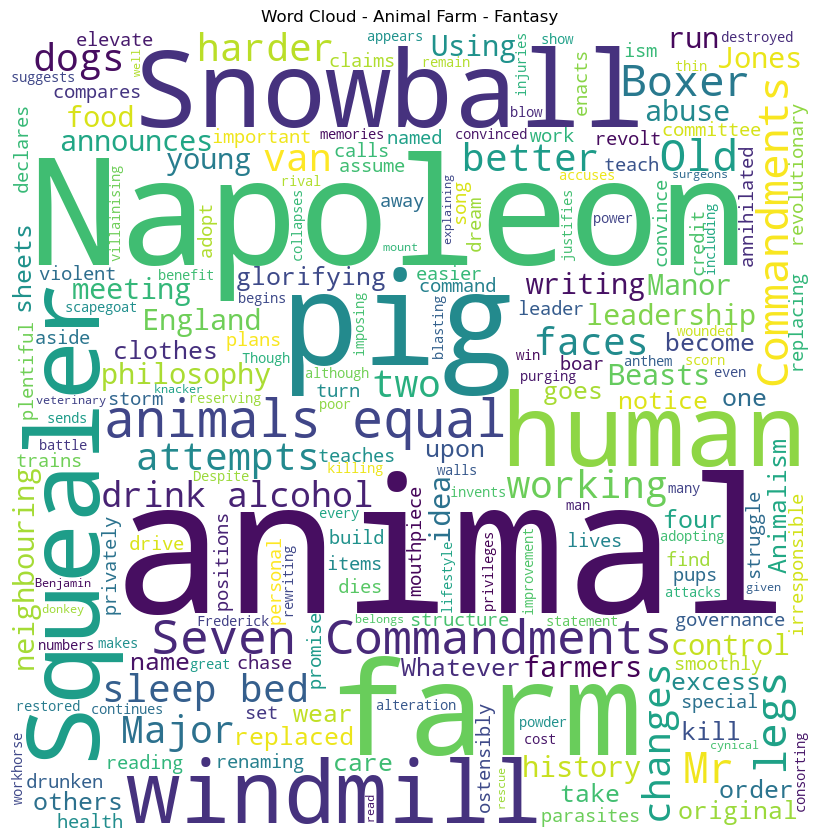

In [36]:

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(books_df_fantasy['CleanSummary'].iloc[0])
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud - '+books_df_fantasy['Title'].iloc[0]+' - Fantasy')
plt.show()


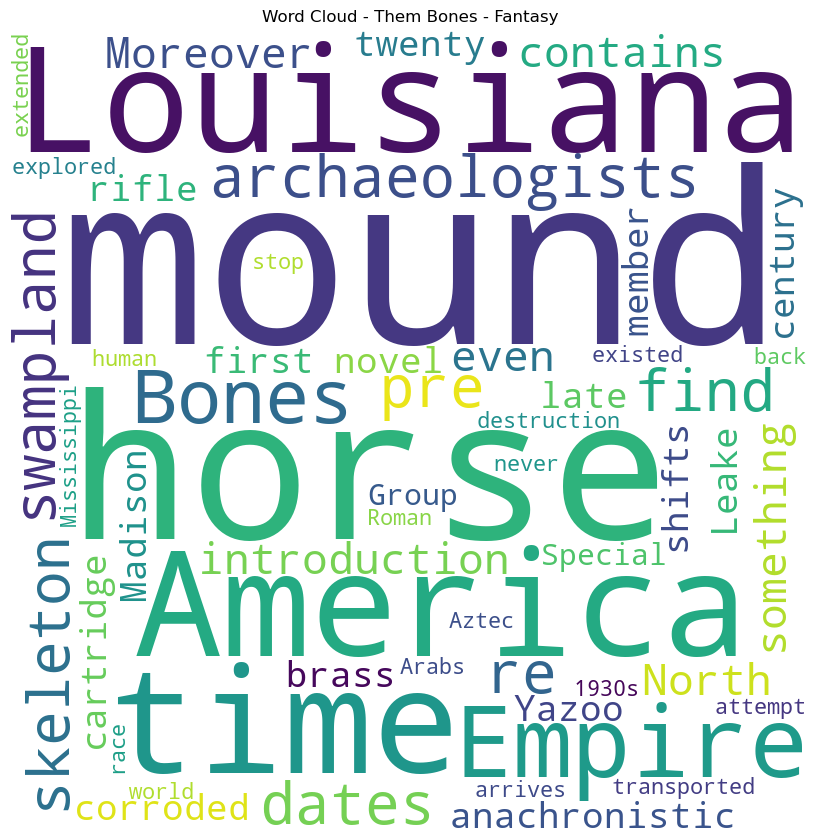

In [37]:

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(books_df_fantasy['CleanSummary'].iloc[1000])
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud - '+books_df_fantasy['Title'].iloc[1000]+' - Fantasy')
plt.show()

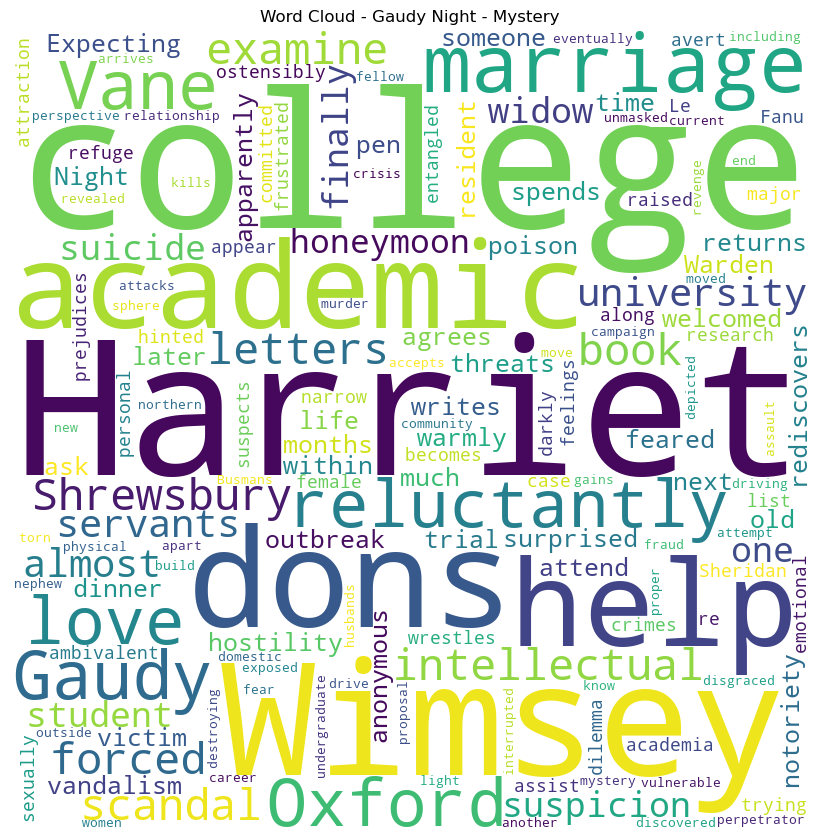

In [38]:

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(books_df_mystery['CleanSummary'].iloc[0])
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud - '+books_df_mystery['Title'].iloc[0]+' - Mystery')
plt.show()

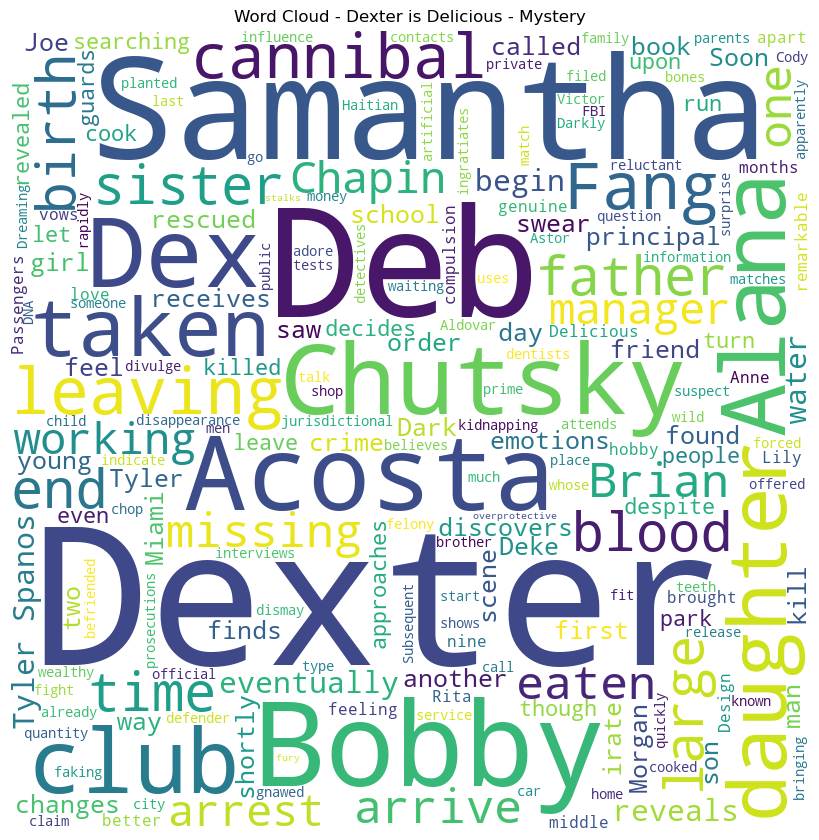

In [39]:

stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(books_df_mystery['CleanSummary'].iloc[1000])
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.title('Word Cloud - '+books_df_mystery['Title'].iloc[1000]+' - Mystery')
plt.show()

#### There are many named entities especially person names that are very prominent across all summaries above. Nothing else really stands out.

In [ ]:
'''from collections import Counter
cnt = Counter()

for word in filtered_tokens:
    cnt[word] += 1

cnt.most_common()
word_freq = pd.DataFrame(cnt.most_common(20),
                             columns=['words', 'count'])
word_freq.head()
fig, ax = plt.subplots(figsize=(12, 8))

# Plot horizontal bar graph
word_freq.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="brown")
ax.set_title("Common Words Found")
plt.show()'''

#### Visualizing length of clean summary across books

In [40]:
#Length of Summary for books
summary_lengths = [len(word_tokenize(s)) for s in books_df_clean_ext['CleanSummary']]
summary = range(0, books_df_clean_ext.shape[0])
summary_df = pd.DataFrame({'summary_length':summary_lengths})


Text(0.5, 1.0, 'Summary Length Across Books')

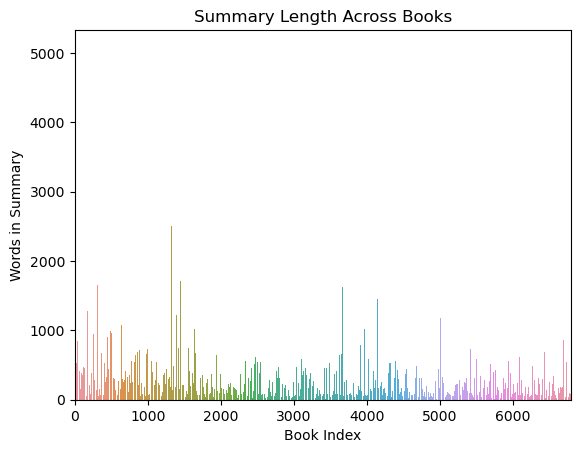

In [41]:
sns.barplot(data=summary_df, x=summary_df.index, y='summary_length')
plt.xticks(np.arange(0, books_df_clean_ext.shape[0], 1000));
plt.xlabel('Book Index')
plt.ylabel('Words in Summary')
plt.title('Summary Length Across Books')

#### There are some outliers but most of the them are under 1000 words.

#### Extract named entities and create a new column

In [43]:
#Named entities in summary
def get_named_entities(text):
    word_tokens = word_tokenize(text)
    pos_tokens = nltk.pos_tag(word_tokens)
    tree = nltk.ne_chunk(pos_tokens)
    named_entities = []
    for word in tree:
        if hasattr(word, 'label'):
            named_entities.append((' '.join(c[0] for c in word.leaves()), word.label()))
    return named_entities
books_df_clean_ext['named entities'] = books_df_clean_ext['CleanSummary'].apply(get_named_entities)
books_df_clean_ext

,Title,BookId,Author,PublishedDate,Genre,Summary,NewGenre,Fiction,GenreNum,CollectiveSummary,CleanSummary,named entities
0,Animal Farm,170448,George Orwell,1945-08-17,Roman à clef Satire Children's literature Spec...,"Old Major, the old boar on the Manor Farm, ca...",fantasy,1,1,"Animal Farm Old Major, the old boar on the Ma...",Animal Farm Old Major old boar Manor Farm call...,"[(Animal, PERSON), (Farm Old, ORGANIZATION), (..."
1,A Clockwork Orange,41817486,Anthony Burgess,1962,Science Fiction Novella Speculative fiction Ut...,"Alex, a teenager living in near-future Englan...",horror,1,3,"A Clockwork Orange Alex, a teenager living in...",Clockwork Orange Alex teenager living near-fut...,"[(Clockwork, PERSON), (Orange Alex, PERSON), (..."
2,The Plague,11989,Albert Camus,1947,Existentialism Fiction Absurdist fiction Novel,The text of The Plague is divided into five p...,philosophy,1,6,The Plague The text of The Plague is divided ...,Plague text Plague divided five parts town Ora...,"[(Plague, GPE), (Plague, PERSON), (Bernard Rie..."
4,A Fire Upon the Deep,77711,Vernor Vinge,NaN,Hard science fiction Science Fiction Speculati...,The novel posits that space around the Milky ...,fantasy,1,1,A Fire Upon the Deep The novel posits that sp...,Fire Upon Deep novel posits space around Milky...,"[(Fire, PERSON), (Upon Deep, PERSON), (Milky W..."
5,All Quiet on the Western Front,355697,Erich Maria Remarque,1929-01-29,War novel Roman à clef,"The book tells the story of Paul Bäumer, a Ge...",historical,1,2,All Quiet on the Western Front The book tells...,Quiet Western Front book tells story Paul Bäum...,"[(Quiet, GPE), (Western Front, LOCATION), (Pau..."
...,...,...,...,...,...,...,...,...,...,...,...,...
10357,Shelter,13595638,Harlan Coben,2011-09-15,NaN,"After Mickey Bolitar moves in with his uncle,...",mystery,1,5,Shelter After Mickey Bolitar moves in with hi...,Shelter Mickey Bolitar moves uncle Myron Bolit...,"[(Shelter, PERSON), (Mickey Bolitar, PERSON), ..."
10358,The Third Lynx,529644,Timothy Zahn,2007,Science Fiction,The story starts with former government agent...,mystery,1,5,The Third Lynx The story starts with former g...,Third Lynx story starts former government agen...,"[(Third, PERSON), (Lynx, ORGANIZATION), (Frank..."
10360,Remote Control,601621,Andy McNab,1997,Thriller Fiction Suspense,The series follows the character of Nick Ston...,thriller,1,8,Remote Control The series follows the charact...,Remote Control series follows character Nick S...,"[(Remote, PERSON), (Control, ORGANIZATION), (N..."
10363,Under Wildwood,10353049,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ...",fantasy,1,1,"Under Wildwood Prue McKeel, having rescued he...",Wildwood Prue McKeel rescued brother Dowager G...,"[(Wildwood, PERSON), (Prue, ORGANIZATION), (Do..."


In [44]:
entities_length = [len(e) for e in books_df_clean_ext['named entities']]
books = range(0, books_df_clean_ext.shape[0])
entity_df = pd.DataFrame({'entities_length':entities_length})

Text(0.5, 1.0, 'Named Entities Across Books')

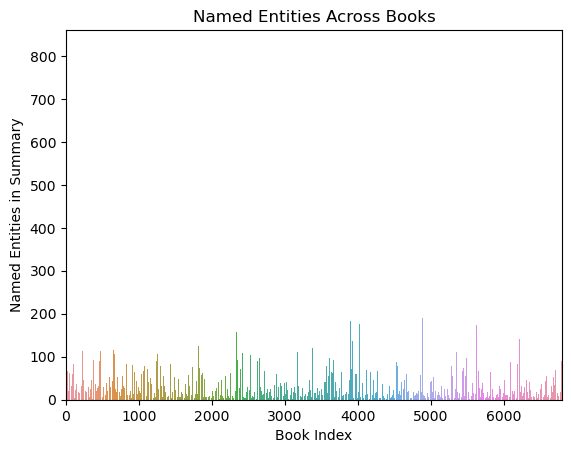

In [45]:
sns.barplot(data=entity_df, x=entity_df.index, y='entities_length')
plt.xticks(np.arange(0, books_df_clean_ext.shape[0], 1000));
plt.xlabel('Book Index')
plt.ylabel('Named Entities in Summary')
plt.title('Named Entities Across Books')

#### Number of named entities is also all over the range but around 50-100 for most. We can use the dataframe as is for modeling first and see what results we get. As a next step, we can remove all named entities, lemmatize/stem the remaining words and try modeling.

### Modeling

#### Modeling with `CleanSummary` with named entities

#### Using TFIDF and LogisticRegression with no hyperparameter tuning

In [46]:

books_df_shuffled = shuffle(books_df_clean_ext, random_state=42)
X = books_df_shuffled[['CleanSummary']]
y = books_df_shuffled['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

tfidf_vec = TfidfVectorizer(use_idf=True)
X_train_vec = tfidf_vec.fit_transform(X_train.squeeze())
X_test_vec = tfidf_vec.transform(X_test.squeeze())
lgr_tfidf = LogisticRegression(fit_intercept=True, max_iter=800)
lgr_tfidf.fit(X_train_vec, y_train.squeeze())

0.7856442439694058
0.6170588235294118


In [ ]:
y_predict_train = lgr_tfidf.predict(X_train_vec)
score = accuracy_score(y_train.squeeze(), y_predict_train)
print("Train accuracy score:"+score)
y_predict_test = lgr_tfidf.predict(X_test_vec)
score = accuracy_score(y_test.squeeze(), y_predict_test)
print("Test accuracy score:"+score)

#### Using Naive Bayes with hyperparam tuning 

In [47]:
books_df_shuffled = shuffle(books_df_clean_ext, random_state=42)
X = books_df_shuffled['CleanSummary']
y = books_df_shuffled['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

bayes_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('bayes', MultinomialNB())])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None], 'bayes__alpha':[1,3,5]}
bayes_tfidf_grid = GridSearchCV(estimator= bayes_tfidf_pipe, cv=5, scoring='accuracy', param_grid=params)
bayes_tfidf_grid.fit(X_train, y_train)

0.658952735830555
0.6082352941176471


In [ ]:
y_predict_train = bayes_tfidf_grid.best_estimator_.predict(X_train)
score = accuracy_score(y_train, y_predict_train)
print("Train accuracy score:"+score)
y_predict_test = bayes_tfidf_grid.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_predict_test)
print("Test accuracy score:"+score)

#### Using Logistic Regression with hyperparam tuning

In [48]:
books_df_shuffled = shuffle(books_df_clean_ext, random_state=42)
X = books_df_shuffled['CleanSummary']
y = books_df_shuffled['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

lgr_ltd_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('lgr', LogisticRegression(max_iter=5000))])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None], 'lgr__C':[1,2,4,5,10,100]}
lgr_ltd_tfidf_grid = GridSearchCV(estimator= lgr_ltd_tfidf_pipe, cv=5, scoring='accuracy', param_grid=params)
lgr_ltd_tfidf_grid.fit(X_train, y_train)
y_predict_train = lgr_ltd_tfidf_grid.best_estimator_.predict(X_train)
score = accuracy_score(y_train, y_predict_train)
print(score)
y_predict_test = lgr_ltd_tfidf_grid.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_predict_test)
print(score)

0.9074328299666601
0.6688235294117647


#### Using Decision Tree with hyperparam tuning

In [49]:
books_df_shuffled = shuffle(books_df_clean_ext, random_state=42)
X = books_df_shuffled['CleanSummary']
y = books_df_shuffled['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

dtree_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('dtree', DecisionTreeClassifier())])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None]}
dtree_tfidf_grid = GridSearchCV(estimator= dtree_tfidf_pipe, cv=5, scoring='accuracy', param_grid=params)
dtree_tfidf_grid.fit(X_train, y_train)
y_predict_train = dtree_tfidf_grid.best_estimator_.predict(X_train)
score = accuracy_score(y_train, y_predict_train)
print(score)
y_predict_test = dtree_tfidf_grid.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_predict_test)
print(score)

1.0
0.44588235294117645


#### Using SVM with hyperparam tuning

In [50]:
books_df_shuffled = shuffle(books_df_clean_ext, random_state=42)
X = books_df_shuffled['CleanSummary']
y = books_df_shuffled['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

svc_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('dtree', SVC())])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None]}
svc_tfidf_grid = GridSearchCV(estimator= svc_tfidf_pipe, cv=5, scoring='accuracy', param_grid=params)
svc_tfidf_grid.fit(X_train, y_train)
y_predict_train = svc_tfidf_grid.best_estimator_.predict(X_train)
score = accuracy_score(y_train, y_predict_train)
print(score)
y_predict_test = svc_tfidf_grid.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_predict_test)
print(score)

0.9327319082172975
0.6405882352941177
